# Optimization

In [122]:
import numpy as np
import ga_PD as ga
from joblib import load
import tensorflow as tf
import csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [123]:
# Load the machine learning model and scaler
# model = tf.keras.models.load_model(r'E:\ai-power-converter\machine-learning\model_4_128_20_20_20_20.h5')
# model_P_D = tf.keras.models.load_model(r'E:\ai-power-converter\machine-learning\split_model\model_1_256_pd.h5')
# model_P_l_C = tf.keras.models.load_model(r'E:\ai-power-converter\machine-learning\split_model\model_2_128_Plc.h5')
# model_P_l_s1 = tf.keras.models.load_model(r'E:\ai-power-converter\machine-learning\split_model\model_2_128_Pls1.h5')

model_P_D = tf.keras.models.load_model(r'D:\Krishna\ai-power-converter-1\machine-learning\split_model\model_1_256_pd.h5')
model_P_l_C = tf.keras.models.load_model(r'D:\Krishna\ai-power-converter-1\machine-learning\split_model\model_2_128_Plc.h5')
model_P_l_s1 = tf.keras.models.load_model(r'D:\Krishna\ai-power-converter-1\machine-learning\split_model\new\model_2_256_Pls1_Pls2_scaler_12_5.h5')
# model_delta_voltage = tf.keras.models.load_model(r'E:\ai-power-converter\machine-learning\split_model\model_3_256_delta_voltage.h5')
# model_delta_current = tf.keras.models.load_model(r'E:\ai-power-converter\machine-learning\split_model\model_4_64_delta_current.h5')
model_P_l_L_Cu = tf.keras.models.load_model(r'D:\Krishna\ai-power-converter-1\machine-learning\split_model\model_4_256_Pllcu.h5')

model_delta_current = tf.keras.models.load_model(r'D:\Krishna\ai-power-converter-1\machine-learning\split_model\new\model_2_256_delta_current_scaler_11_5.h5')
model_delta_voltage = tf.keras.models.load_model(r'D:\Krishna\ai-power-converter-1\machine-learning\split_model\new\model_4_256_delta_voltage_scaler_11_5.h5')

model_current = tf.keras.models.load_model(r'D:\Krishna\ai-power-converter-1\machine-learning\split_model\new\model_2_256_delta_current_scaler_11_5.h5')
model_voltage = tf.keras.models.load_model(r'D:\Krishna\ai-power-converter-1\machine-learning\model_3_64_voltage_scaler_14_5.h5')


# csv_file_capacitance = r'E:\ai-power-converter\dataset\capacitor_lookup_table.csv'  # Replace 'your_csv_file.csv' with the path to your CSV file
# csv_file_inductance = r'E:\ai-power-converter\dataset\inductor_lookup_table.csv'

csv_file_capacitance = r'D:\Krishna\ai-power-converter-1\dataset\capacitor_lookup_table.csv'  # Replace 'your_csv_file.csv' with the path to your CSV file
csv_file_inductance = r'D:\Krishna\ai-power-converter-1\dataset\inductor_lookup_table.csv'

# Define constraint values
V_out = 12
Vol_lim = 7e-6
Delta_Vo_percent_lim = 1
Delta_IL_percent_lim = 10
Voltage_percent_lim = 0.2

# Genetic algorithm parameters
sol_per_pop = 8
num_parents_mating = 4
pop_size = (sol_per_pop, 4)  # We have 3 variables: fs, L, C
num_generations = 10

# Generate initial population
L_range = (30e-6, 2000e-6)  # Range for L
C_range = (30e-6, 200e-6)   # Range for C
fsw_range = (20e3, 200e3)    # Range for fsw
t_dt_range = (0.178e-6, 1e-6) # Range for dead time

num_values = sol_per_pop

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

# Define mutation ranges for each parameter
mutation_ranges = [(30e-6, 100e-6), (20e-6, 100e-6), (10, 1000), (0.001e-6, 0.1e-6)]

# # Create arrays of discrete L, C, and fsw values within the specified ranges
L_values = np.linspace(L_range[0], L_range[1], num=num_values)
C_values = np.linspace(C_range[0], C_range[1], num=num_values)
t_dt_values = np.linspace(t_dt_range[0], t_dt_range[1], num=num_values)

# Round the values to the desired number of decimal places
L_values = np.around(L_values, decimals=6)
C_values = np.around(C_values, decimals=6)
t_dt_values = np.around(t_dt_values, decimals=9)

fsw_values = np.linspace(fsw_range[0], fsw_range[1], num=num_values, dtype=int)

initial_population = np.column_stack((L_values, C_values, fsw_values, t_dt_values))

# Function

## Scaling

In [124]:
def scale_input_values(input_values):

    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array

    # Scale L
    input_values_scaled[0] = (input_values[0] - L_min) / (L_max - L_min)

    # Scale C
    input_values_scaled[1] = (input_values[1] - C_min) / (C_max - C_min)

    # Scale fsw
    input_values_scaled[2] = (input_values[2] - fsw_min) / (fsw_max - fsw_min)

    input_values_scaled[3] = (input_values[3] - t_dt_min) / (t_dt_max - t_dt_min)
    # Make predictions using the model

    # Reshape the input data to match the expected shape of the model
    input_values_reshaped = input_values_scaled.reshape((1, -1))

    return input_values_reshaped


def inverse_scale_input_values(scaled_input_values):
    # Reshape the scaled input values to the original shape
    input_values_scaled = scaled_input_values.reshape(-1)

    # Reverse scaling for L
    input_values_scaled[0] = input_values_scaled[0] * (L_max - L_min) + L_min

    # Reverse scaling for C
    input_values_scaled[1] = input_values_scaled[1] * (C_max - C_min) + C_min

    # Reverse scaling for fsw
    input_values_scaled[2] = input_values_scaled[2] * (fsw_max - fsw_min) + fsw_min

    # Reverse scaling for t_dt
    input_values_scaled[3] = input_values_scaled[3] * (t_dt_max - t_dt_min) + t_dt_min

    # Reshape the input data to match the original shape
    input_values_reshaped = input_values_scaled.reshape((1, -1))

    return input_values_reshaped


In [125]:
# Generate some sample input data
input_values = [1500e-6, 700e-6, 120e3, 0.6e-6]

# Scale the input data
scaled_input = scale_input_values(input_values)
print("Scaled Input Values:")
print(scaled_input)

# Inverse scale the scaled input data
inverse_scaled_input = inverse_scale_input_values(scaled_input)
print("\nInverse Scaled Input Values:")
print(inverse_scaled_input)

# Compare with original input data
print("\nOriginal Input Values:")
print(input_values)


Scaled Input Values:
[[0.74619289 0.69387755 0.55555556 0.513382  ]]

Inverse Scaled Input Values:
[[1.5e-03 7.0e-04 1.2e+05 6.0e-07]]

Original Input Values:
[0.0015, 0.0007, 120000.0, 6e-07]


In [126]:
def custom_scaling_minmax(X):
    scaled_features = []  # List to store scaled features
    
    # Define custom minimum and maximum values for each feature
    feature_ranges = {
        'L': (30e-6, 2000e-6),
        'C': (20e-6, 1000e-6),
        'fsw': (20e3, 200e3),
        't_dt': (0.178e-6, 1e-6)
    }

    for i, feature_name in enumerate(['L', 'C', 'fsw', 't_dt']):
        # Extract min and max values for the current feature
        feature_min, feature_max = feature_ranges[feature_name]
        
        # Define MinMaxScaler with custom input range
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit([[feature_min], [feature_max]])
        
        # Transform the current feature using the scaler
        # scaled_feature = scaler.transform(X[:, i].reshape(-1, 1))
        
        scaled_feature = scaler.transform(X.reshape(-1, 1))
        # Append the scaled feature to the list
        scaled_features.append(scaled_feature)
    
    # Combine the scaled features into a single array
    X_scaled = np.hstack(scaled_features)
    
    return X_scaled

In [127]:
import pandas as pd
df_data = pd.read_csv(r"D:\Krishna\ai-power-converter-1\simulation_results_new_20_20_20_20.csv")
df_data_1 = pd.read_csv(r"D:\Krishna\ai-power-converter-1\simulation_results_newest_15_4.csv")

y_delta_current_1 = df_data[["delta_current"]].values  # Adjust column names as per your dataset
y_delta_voltage_1 = df_data[["delta_voltage"]].values
y_Pl_s1_1 = df_data[["Pl_s1"]].values
y_voltage_1 = df_data_1[["voltage"]].values  # Adjust column names as per your dataset


scaler_y_delta_current = MinMaxScaler(feature_range=(0, 1))
scaler_y_delta_voltage = MinMaxScaler(feature_range=(0, 1))
scaler_y_Pl_s1 = MinMaxScaler(feature_range=(0, 1))
scaler_voltage = MinMaxScaler(feature_range=(0, 1))


# Fit the scaler to your target variable and transform it
y_scaled_delta_current_1 = scaler_y_delta_current.fit_transform(y_delta_current_1)
y_scaled_delta_voltage_1 = scaler_y_delta_voltage.fit_transform(y_delta_voltage_1)
y_scaled_Pl_s1_1 = scaler_y_Pl_s1.fit_transform(y_Pl_s1_1)
y_scaled_voltage_1 = scaler_voltage.fit_transform(y_voltage_1)

## Calculate Fitness

In [128]:

def calculate_fitness(individual):

    input_values_scaled = scale_input_values(individual)

    # prediction = model.predict(input_values_scaled, verbose=0)
    
    # Extract predictions from the model output
    P_l_s1_ori = model_P_l_s1.predict(input_values_scaled, verbose=0)    
    P_l_s1 = scaler_y_Pl_s1.inverse_transform(P_l_s1_ori)
    
    P_l_s2 = P_l_s1
    P_l_C = model_P_l_C.predict(input_values_scaled, verbose=0)
    P_l_L_Cu = model_P_l_L_Cu.predict(input_values_scaled, verbose=0)
    P_D = model_P_D.predict(input_values_scaled, verbose=0)

    # P_l_s1 = prediction[0][2]
    # P_l_s2 = prediction[0][3]
    # P_l_C = prediction[0][4]
    # P_l_L_Cu = prediction[0][5]
    # P_D = prediction[0][6]
    
    # Calculate the objective function value based on the given equation
    objective_value = P_l_s1 + P_l_s2 + P_l_L_Cu + P_l_C + P_D
    
    return objective_value

# def calculate_fitness(individual):
#     input_values_scaled = scale_input_values(individual)

#     # Make predictions using the models
#     P_l_s1_ori = model_P_l_s1.predict(input_values_scaled, verbose=0)    
#     P_l_s1 = scaler_y_Pl_s1.inverse_transform(P_l_s1_ori)
    
#     P_l_s2 = P_l_s1
#     P_l_C = model_P_l_C.predict(input_values_scaled, verbose=0)
#     P_l_L_Cu = model_P_l_L_Cu.predict(input_values_scaled, verbose=0)
#     P_D = model_P_D.predict(input_values_scaled, verbose=0)

#     # Calculate the objective function value based on the given equation
#     objective_value = P_l_s1 + P_l_s2 + P_l_L_Cu + P_l_C + P_D

#     # Add a penalty if the individual does not meet the constraints
#     penalty = 0
#     if not check_constraints(individual):
#         penalty = 1e6  # Large penalty for constraint violation

#     return objective_value + penalty


## Search Volume

### Capacitance

In [129]:
def search_volume_capacitance(capacitance, csv_file):
    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        capacitance_values = []
        volume_values = []
        for row in reader:
            capacitance_values.append(float(row['Capacitance']))
            volume_values.append(float(row['Total Volume']))
        
        # Find the index of the nearest capacitance value
        nearest_idx = np.abs(np.array(capacitance_values) - capacitance).argmin()
        nearest_capacitance = capacitance_values[nearest_idx]
        nearest_volume = volume_values[nearest_idx]
        
        return nearest_capacitance, nearest_volume

### Inductance

In [130]:

def search_volume_inductance(inductance, csv_file):
    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        inductance_values = []
        volume_values = []
        for row in reader:
            inductance_values.append(float(row['Inductance']))
            volume_values.append(float(row['Volume']))
        
        # Find the index of the nearest inductance value
        nearest_idx = np.abs(np.array(inductance_values) - inductance).argmin()
        nearest_inductance = inductance_values[nearest_idx]
        nearest_volume = volume_values[nearest_idx]
        
        return nearest_inductance, nearest_volume


## Check Constraints

In [131]:
feature_ranges = {
    'L': (30e-6, 2000e-6),  # Custom range for feature L
    'C': (20e-6, 1000e-6),   # Custom range for feature C
    'fsw': (20e3, 200e3),    # Custom range for feature fsw
    't_dt': (0.178e-6, 1e-6) # Custom range for feature t_dt
}



# Define the constraints function
def check_constraints(individual):
    L = individual[0]
    C = individual[1]
    fs = individual[2]
    t_dt = individual[3]
    
    # Define the constraint values
    nearest_C, Vol_C  = search_volume_capacitance(C, csv_file_capacitance) # Define Vol_L based on your problem-specific requirements
    nearest_L, Vol_L  = search_volume_inductance(L, csv_file_inductance)

    # Prepare input values for prediction

    input_values = np.array([L, C, fs, t_dt])
    # Apply Min-Max normalization separately for each input feature
    
    # print("input_values", input_values)
    input_values_scaled = scale_input_values(input_values)
    # input_values_scaled = scaler_y_new_20_20_20_20.transform(input_values)
    # print("scaled", input_values_scaled)
    # prediction = model.predict(input_values_scaled, verbose = 0)

    # Extract predictions from the model output
    Delta_IL_percent_ori = model_delta_current.predict(input_values_scaled, verbose = 0)
    Delta_Vo_percent_ori = model_delta_voltage.predict(input_values_scaled, verbose = 0)

    Voltage_ori = model_voltage.predict(input_values_scaled, verbose = 0)
    Voltage = scaler_voltage.inverse_transform(Voltage_ori)
    # Voltage = 12
    # print("Voltage:", Voltage)

    
    # Delta_IL_percent = prediction[0][0]
    # Delta_Vo_percent = prediction[0][1]
    # print("Shape \n")
    # print(Delta_IL_percent_ori.shape)
    # print(Delta_Vo_percent_ori.shape)
    # scaler_y_new_loaded = load(r'E:\ai-power-converter\machine-learning\scaler_y_new_20_20_20_20.joblib')
    
    # # Fit the scaler with the training data
    # scaler_y_new_loaded.fit([[feature_min], [feature_max]])
    # Inverse transform the predictions
    Delta_IL_percent = scaler_y_delta_current.inverse_transform(Delta_IL_percent_ori)
    Delta_Vo_percent = scaler_y_delta_voltage.inverse_transform(Delta_Vo_percent_ori)

    # print("delta_IL inverse",Delta_IL_percent)
    # print("delta_Vo inverse",Delta_Vo_percent)

    # Delta_IL_percent = inverse_scale_input_values(Delta_IL_percent_ori)
    # Delta_Vo_percent = inverse_scale_input_values(Delta_Vo_percent_ori)

    # Define the acceptable voltage range
    acceptable_voltage_range = (V_out - Voltage_percent_lim * V_out, V_out + Voltage_percent_lim * V_out)

    # Check if Voltage_ori is within the acceptable voltage range


    # Check if constraints are satisfied
    constraint1 = Vol_C + Vol_L  <= Vol_lim
    constraint2 = Delta_Vo_percent <= Delta_Vo_percent_lim
    constraint3 = Delta_IL_percent <= Delta_IL_percent_lim
    constraint4 = (Voltage >= acceptable_voltage_range[0]) and (Voltage <= acceptable_voltage_range[1])
    
    # print("Constraint 1", constraint1)
    # print("Constraint 2", constraint2)
    # print("Constraint 3", constraint3)
    # print("Constraint 4", constraint4)

    # print("Constraint:", constraint1 and constraint2 and constraint3 and constraint4)

    # return constraint1 and constraint2 and constraint3
    return constraint1 and constraint2 and constraint3 and constraint4 

# Genetic Algorithm

Generation :  0
Population [[3.00000e-05 3.00000e-05 2.00000e+04 1.78000e-07]
 [3.11000e-04 5.40000e-05 4.57140e+04 2.95000e-07]
 [5.93000e-04 7.90000e-05 7.14280e+04 4.13000e-07]
 [8.74000e-04 1.03000e-04 9.71420e+04 5.30000e-07]
 [1.15600e-03 1.27000e-04 1.22857e+05 6.48000e-07]
 [1.43700e-03 1.51000e-04 1.48571e+05 7.65000e-07]
 [1.71900e-03 1.76000e-04 1.74285e+05 8.83000e-07]
 [2.00000e-03 2.00000e-04 2.00000e+05 1.00000e-06]]
Best result: 1.567535
Best solution index: 7
Best solution: [2.e-03 2.e-04 2.e+05 1.e-06]
Best solutions array: [array([2.e-03, 2.e-04, 2.e+05, 1.e-06])]
Best fitness: [1.567535]
Best fitnesses: [1.567535]
Parents
[[1.2190e-03 7.6000e-05 6.0139e+04 2.8000e-07]
 [1.8030e-03 6.6000e-05 3.6323e+04 2.0300e-07]
 [6.2200e-04 7.4000e-05 8.8295e+04 4.6200e-07]
 [1.7230e-03 7.2000e-05 4.4547e+04 2.8700e-07]]
Crossover
[[1.2190e-03 7.6000e-05 3.6323e+04 2.0300e-07]
 [1.8030e-03 6.6000e-05 8.8295e+04 4.6200e-07]
 [6.2200e-04 7.4000e-05 4.4547e+04 2.8700e-07]
 [1.7230e-

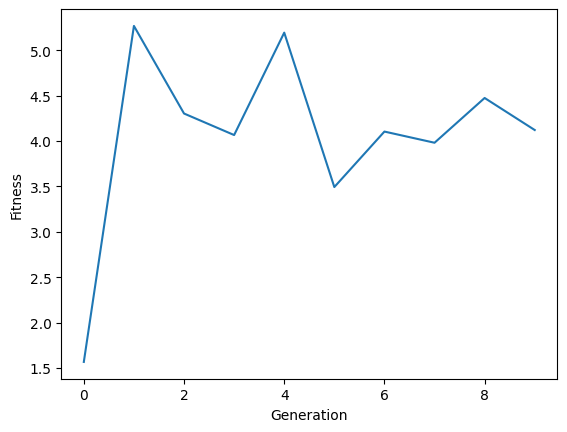

In [132]:

# Genetic Algorithm optimization
best_outputs = []
best_solutions = []  # Store the best solution for each generation
best_fitnesses = []  # Store the best fitness for each generation
new_population = initial_population

for generation in range(num_generations):
    print("Generation : ", generation)
    
    # Measuring the fitness of each chromosome in the population.
    fitness_values = []
    delta_IL_percent_values = []
    delta_Vo_percent_values = []
    for individual in new_population:
        fitness_value = calculate_fitness(individual)
        # print('fitness value', fitness_value)
        fitness_values.append(fitness_value)

    fitness = np.array(fitness_values)
    # print('cek fitness', fitness)

    print("Population", new_population)
    best_outputs.append(np.min(fitness))
    print("Best result:", np.min(fitness))

    # Find the index of the best solution in this generation
    best_solution_idx = np.argmin(fitness)
    print("Best solution index:", best_solution_idx)

    # Retrieve the best solution from the population
    best_solution = new_population[best_solution_idx].copy()  # Copy the best solution
    print("Best solution:", best_solution)

    # Append the current best solution to the list of best solutions
    best_solutions.append(best_solution.copy())  # Append a copy of the best solution
    print("Best solutions array:", best_solutions)

    # Append the corresponding fitness value to the list of best fitnesses
    best_fitness = fitness[best_solution_idx][0]
    # best_fitness = fitness[best_solution_idx][0]

    best_fitnesses.append(best_fitness[0])
    print("Best fitness:", best_fitness)
    print("Best fitnesses:", best_fitnesses)



    # Check and enforce constraints
    for i in range(sol_per_pop):
        if not check_constraints(new_population[i]):
            # Regenerate individual until it satisfies the constraints
            while not check_constraints(new_population[i]):
                # Generate all possible values within the specified range with the desired increment
                L_values_all = np.arange(L_range[0], L_range[1] + 1e-6, 1e-6)
                C_values_all = np.arange(C_range[0], C_range[1] + 1e-6, 1e-6)
                t_dt_values_all = np.arange(t_dt_range[0], t_dt_range[1] + 0.001e-6, 0.001e-6)

                    
                # Generate new random values for fsw, L, and C
                new_L = np.random.choice(L_values_all, 1, replace=False)
                new_C = np.random.choice(C_values_all, 1, replace=False)
                new_fsw = np.random.randint(fsw_range[0], fsw_range[1] + 1, size=1)
                new_t_dt = np.random.choice(t_dt_values_all, 1, replace=False)

                new_population[i] = [new_L[0], new_C[0], new_fsw[0], new_t_dt[0]]
                # new_population[i] = generate_feasible_solution(L_range, C_range, fsw_range)


    # Selecting the best parents in the population for mating.
    parents = ga.select_mating_pool(new_population, fitness, num_parents_mating)
    print("Parents")
    print(parents)

    # Generating next generation using crossover.
    offspring_crossover = ga.crossover(parents, offspring_size=(pop_size[0]-parents.shape[0], 4))
    print("Crossover")
    print(offspring_crossover)

    # Adding some variations to the offspring using mutation.
    # offspring_mutation = ga.mutation(offspring_crossover, 2)
    # offspring_mutation = ga.mutation(offspring_crossover, mutation_ranges, 1)
    offspring_mutation = ga.mutation(offspring_crossover, mutation_ranges, L_range, C_range, fsw_range, t_dt_range, 2)
    print("Mutation")
    print(offspring_mutation)

    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

# Getting the best solution after iterating finishing all generations.
# At first, the fitness is calculated for each solution in the final generation.
fitness_values = []

for individual in new_population:
    fitness_value= calculate_fitness(individual)
    fitness_values.append(fitness_value)

fitness = np.array(fitness_values)


# Then return the index of that solution corresponding to the best fitness.
# best_match_idx = np.where(fitness == np.min(fitness))
best_match_idx = np.where(fitness == np.min(fitness))[0]

print("Best solution : ", new_population[best_match_idx, :])
# print("cek")
print("Best solution fitness : ", fitness[best_match_idx])
# print("ceki")

plt.plot(best_outputs)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()

In [133]:
print(best_fitnesses)

[1.567535, 5.267181, 4.3026743, 4.0657115, 5.193269, 3.4929788, 4.103928, 3.980901, 4.4738317, 4.1209416]


In [134]:
# Print the best solutions for each generation
print("Best solutions for each generation:")
for i, (solution, fitness) in enumerate(zip(best_solutions, best_fitnesses)):
    print("Generation", i, ":", "Fitness:", fitness)
    print("Solution (L, C, fsw):", solution)
    
    # Calculate additional information for the current solution
    L = solution[0]
    C = solution[1]
    fs = solution[2]
    t_dt = solution[3]
    nearest_C, Vol_C = search_volume_capacitance(C, csv_file_capacitance)
    nearest_L, Vol_L = search_volume_inductance(L, csv_file_inductance)
    
    # Prepare input values for prediction
    input_values = np.array([L, C, fs, t_dt])
    input_values_scaled = np.zeros_like(input_values, dtype=float)
    input_values_scaled[0] = (input_values[0] - L_min) / (L_max - L_min)
    input_values_scaled[1] = (input_values[1] - C_min) / (C_max - C_min)
    input_values_scaled[2] = (input_values[2] - fsw_min) / (fsw_max - fsw_min)
    input_values_scaled[3] = (input_values[3] - t_dt_min) / (t_dt_max - t_dt_min)
    input_values_reshaped = input_values_scaled.reshape((1, -1))
    
    # Make predictions using the model
    # prediction = model.predict(input_values_reshaped, verbose=0)
    # print("Prediction: ", prediction)
    # print("Shape: ", prediction.shape)
    # Delta_IL_percent = prediction[0][0]
    # Delta_Vo_percent = prediction[0][1]
    Delta_IL_percent = model_delta_current.predict(input_values_reshaped, verbose=0)
    Delta_Vo_percent = model_delta_voltage.predict(input_values_reshaped, verbose=0)
    Voltage_ori = model_voltage.predict(input_values_reshaped, verbose = 0)

    Voltage = scaler_voltage.inverse_transform(Voltage_ori)
    Delta_IL_percent = scaler_y_delta_current.inverse_transform(Delta_IL_percent)
    Delta_Vo_percent = scaler_y_delta_voltage.inverse_transform(Delta_Vo_percent)


    print("Volume L:", Vol_L)
    print("Volume C:", Vol_C)
    print("Delta Vo percent:", Delta_Vo_percent)
    print("Delta Il percent:", Delta_IL_percent)
    print("Voltage:", Voltage)
    print()  # Add a blank line for readability


Best solutions for each generation:
Generation 0 : Fitness: 1.567535
Solution (L, C, fsw): [2.e-03 2.e-04 2.e+05 1.e-06]
Volume L: 2.0828406321502e-06
Volume C: 6.86e-07
Delta Vo percent: [[6.3104124]]
Delta Il percent: [[15.964979]]
Voltage: [[2.2323923]]

Generation 1 : Fitness: 5.267181
Solution (L, C, fsw): [6.2200e-04 7.4000e-05 8.8295e+04 4.6200e-07]
Volume L: 2.0828406321502e-06
Volume C: 3.316e-06
Delta Vo percent: [[0.7426437]]
Delta Il percent: [[7.556418]]
Voltage: [[9.600572]]

Generation 2 : Fitness: 4.3026743
Solution (L, C, fsw): [7.4100e-04 1.4800e-04 6.5596e+04 1.0000e-06]
Volume L: 2.0828406321502e-06
Volume C: 4.996e-06
Delta Vo percent: [[3.4899857]]
Delta Il percent: [[16.81785]]
Voltage: [[8.443588]]

Generation 3 : Fitness: 4.0657115
Solution (L, C, fsw): [7.2000e-04 1.3700e-04 8.7238e+04 1.0000e-06]
Volume L: 2.0828406321502e-06
Volume C: 3.101e-06
Delta Vo percent: [[4.1781425]]
Delta Il percent: [[13.239948]]
Voltage: [[7.4056334]]

Generation 4 : Fitness: 5.1

## Ranking

Sorted Solutions:
Rank: 1
Solution (L, C, fsw, t_dt): [2.e-03 2.e-04 2.e+05 1.e-06]
Fitness: 1.567535
Volume L: 2.0828406321502e-06
Volume C: 6.86e-07
Delta Vo: [[6.3104124]]
Delta IL: [[15.964979]]
Voltage: [[7.584478]]
P_l_s1:  [[0.6848769]]
P_l_s2:  [[0.6848769]]
P_l_C:  [[7.404231e-07]]
P_l_L_Cu:  [[0.10054594]]
P_D:  [[0.09723458]]
Losses Total: [[1.567535]]

Rank: 2
Solution (L, C, fsw, t_dt): [4.63000e-04 4.20000e-05 1.12898e+05 1.00000e-06]
Fitness: 3.4929788
Volume L: 2.0828406321502e-06
Volume C: 4.241e-06
Delta Vo: [[1.8454012]]
Delta IL: [[9.483709]]
Voltage: [[7.584478]]
P_l_s1:  [[1.5199466]]
P_l_s2:  [[1.5199466]]
P_l_C:  [[0.01479848]]
P_l_L_Cu:  [[0.29689124]]
P_D:  [[0.14139597]]
Losses Total: [[3.4929788]]

Rank: 3
Solution (L, C, fsw, t_dt): [6.9600e-04 3.0000e-05 8.8783e+04 1.0000e-06]
Fitness: 3.980901
Volume L: 2.0828406321502e-06
Volume C: 1.564e-06
Delta Vo: [[1.4638673]]
Delta IL: [[6.772362]]
Voltage: [[7.584478]]
P_l_s1:  [[1.6274416]]
P_l_s2:  [[1.6274416]]

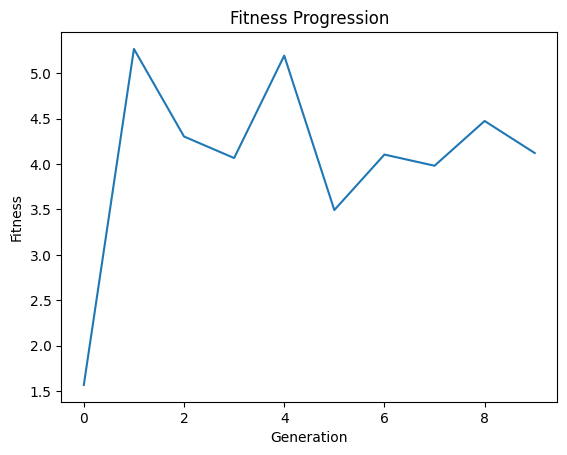

In [135]:
# Your additional code snippet for printing and sorting the results
# Define lists to store the results
volume_L_values = []
volume_C_values = []
delta_Vo_values = []
delta_IL_values = []
P_l_s1_values = []
P_l_s2_values = []
P_l_C_values = []
P_l_L_Cu_values = []
P_D_values = []
Voltage_values = []
solutions = []

# Iterate over different generations
for i, (solution, fitness) in enumerate(zip(best_solutions, best_fitnesses)):
    # Calculate volume values and delta Vo for the current solution
    L = solution[0]
    C = solution[1]
    fs = solution[2]
    t_dt = solution[3]
    nearest_C, Vol_C = search_volume_capacitance(C, csv_file_capacitance)
    nearest_L, Vol_L = search_volume_inductance(L, csv_file_inductance)

    input_values = np.array([L, C, fs, t_dt])
    input_values_scaled = np.zeros_like(input_values, dtype=float)
    input_values_scaled[0] = (input_values[0] - L_min) / (L_max - L_min)
    input_values_scaled[1] = (input_values[1] - C_min) / (C_max - C_min)
    input_values_scaled[2] = (input_values[2] - fsw_min) / (fsw_max - fsw_min)
    input_values_scaled[3] = (input_values[3] - t_dt_min) / (t_dt_max - t_dt_min)
    input_values_reshaped = input_values_scaled.reshape((1, -1))

    P_l_s1_ori = model_P_l_s1.predict(input_values_reshaped, verbose=0)
    P_l_s1 = scaler_y_Pl_s1.inverse_transform(P_l_s1_ori)
    P_l_s2 = P_l_s1
    P_l_C = model_P_l_C.predict(input_values_reshaped, verbose=0)
    P_l_L_Cu = model_P_l_L_Cu.predict(input_values_reshaped, verbose=0)
    P_D = model_P_D.predict(input_values_reshaped, verbose=0)
    
    Delta_IL_percent = model_delta_current.predict(input_values_reshaped, verbose = 0)
    Delta_Vo_percent = model_delta_voltage.predict(input_values_reshaped, verbose = 0)
    Voltage_ori = model_voltage.predict(input_values_reshaped, verbose = 0)

    Voltage = scaler_voltage.inverse_transform(Voltage_ori)
    Delta_IL_percent = scaler_y_delta_current.inverse_transform(Delta_IL_percent)
    Delta_Vo_percent = scaler_y_delta_voltage.inverse_transform(Delta_Vo_percent)


    # prediction = model.predict(input_values_reshaped, verbose=0)
    # Delta_IL_percent = prediction[0][0]
    # Delta_Vo_percent = prediction[0][1]
    # P_l_s1 = prediction[0][2]
    # P_l_s2 = prediction[0][3]
    # P_l_C = prediction[0][4]
    # P_l_L_Cu = prediction[0][5]
    # P_D = prediction[0][6]
    
    # Store the volume values, delta Vo, and solution for sorting
    volume_L_values.append(Vol_L)
    volume_C_values.append(Vol_C)
    Voltage_values.append(Voltage)
    delta_Vo_values.append(Delta_Vo_percent)
    delta_IL_values.append(Delta_IL_percent)
    P_l_s1_values.append(P_l_s1)
    P_l_s2_values.append(P_l_s2)
    P_l_C_values.append(P_l_C)
    P_l_L_Cu_values.append(P_l_L_Cu)
    P_D_values.append(P_D)

    solutions.append((solution, fitness, Vol_L, Vol_C, Voltage, Delta_Vo_percent, Delta_IL_percent, P_l_s1, P_l_s2, P_l_C, P_l_L_Cu, P_D))

# Sort the solutions based on fitness values in ascending order
sorted_solutions = sorted(solutions, key=lambda x: x[1])

# Print the sorted solutions
print("Sorted Solutions:")
for rank, (solution, fitness, vol_L, vol_C, voltage, delta_Vo, delta_IL, P_l_s1, P_l_s2, P_l_C, P_l_L_Cu, P_D) in enumerate(sorted_solutions):
    print("Rank:", rank + 1)
    print("Solution (L, C, fsw, t_dt):", solution)
    print("Fitness:", fitness)
    print("Volume L:", vol_L)
    print("Volume C:", vol_C)
    print("Delta Vo:", delta_Vo)
    print("Delta IL:", delta_IL)
    print("Voltage:", Voltage)
    print("P_l_s1: ", P_l_s1)
    print("P_l_s2: ", P_l_s2)
    print("P_l_C: ", P_l_C)
    print("P_l_L_Cu: ", P_l_L_Cu)
    print("P_D: ", P_D)
    print("Losses Total:", P_l_s1 + P_l_s2 + P_l_C + P_l_L_Cu + P_D)
    print()

# Plot the fitness values for each generation
plt.plot(best_outputs)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Progression")
plt.show()


## Ranking with constraint

Sorted Solutions:
Rank: 1
Solution (L, C, fsw, t_dt): [8.5500e-04 6.6000e-05 5.6639e+04 4.0600e-07]
Fitness: 5.193269
Volume L: 2.0828406321502e-06
Volume C: 2.102e-06
Voltage: [[10.405483]]
Delta Vo: [[0.57104915]]
Delta IL: [[8.529575]]
P_l_s1:  [[2.0016646]]
P_l_s2:  [[2.0016646]]
P_l_C:  [[0.05510678]]
P_l_L_Cu:  [[1.0875592]]
P_D:  [[0.04727345]]
Losses Total: [[5.193269]]

Rank: 2
Solution (L, C, fsw, t_dt): [6.2200e-04 7.4000e-05 8.8295e+04 4.6200e-07]
Fitness: 5.267181
Volume L: 2.0828406321502e-06
Volume C: 3.316e-06
Voltage: [[9.600572]]
Delta Vo: [[0.7426437]]
Delta IL: [[7.556418]]
P_l_s1:  [[2.114843]]
P_l_s2:  [[2.114843]]
P_l_C:  [[0.02858073]]
P_l_L_Cu:  [[0.9297324]]
P_D:  [[0.07918219]]
Losses Total: [[5.267181]]



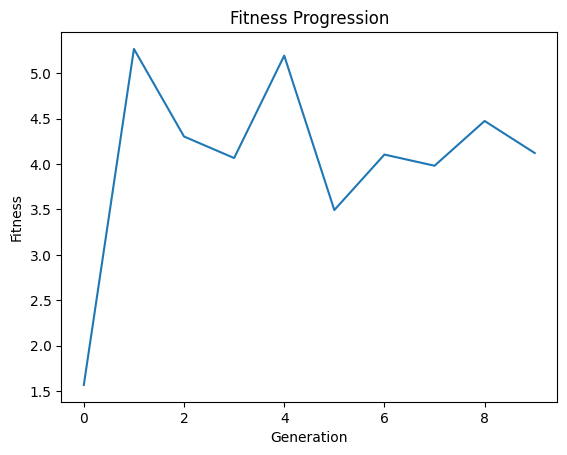

In [136]:
# Your additional code snippet for printing and sorting the results
# Define lists to store the results
volume_L_values = []
volume_C_values = []
delta_Vo_values = []
delta_IL_values = []
P_l_s1_values = []
P_l_s2_values = []
P_l_C_values = []
P_l_L_Cu_values = []
P_D_values = []
Voltage_values = []
solutions = []

# Iterate over different generations
for i, (solution, fitness) in enumerate(zip(best_solutions, best_fitnesses)):
    # Calculate volume values and delta Vo for the current solution
    L = solution[0]
    C = solution[1]
    fs = solution[2]
    t_dt = solution[3]
    nearest_C, Vol_C = search_volume_capacitance(C, csv_file_capacitance)
    nearest_L, Vol_L = search_volume_inductance(L, csv_file_inductance)

    input_values = np.array([L, C, fs, t_dt])
    input_values_scaled = np.zeros_like(input_values, dtype=float)
    input_values_scaled[0] = (input_values[0] - L_min) / (L_max - L_min)
    input_values_scaled[1] = (input_values[1] - C_min) / (C_max - C_min)
    input_values_scaled[2] = (input_values[2] - fsw_min) / (fsw_max - fsw_min)
    input_values_scaled[3] = (input_values[3] - t_dt_min) / (t_dt_max - t_dt_min)
    input_values_reshaped = input_values_scaled.reshape((1, -1))

    P_l_s1_ori = model_P_l_s1.predict(input_values_reshaped, verbose=0)
    P_l_s1 = scaler_y_Pl_s1.inverse_transform(P_l_s1_ori)
    P_l_s2 = P_l_s1
    P_l_C = model_P_l_C.predict(input_values_reshaped, verbose=0)
    P_l_L_Cu = model_P_l_L_Cu.predict(input_values_reshaped, verbose=0)
    P_D = model_P_D.predict(input_values_reshaped, verbose=0)
    Delta_IL_percent = model_delta_current.predict(input_values_reshaped, verbose = 0)
    Delta_Vo_percent = model_delta_voltage.predict(input_values_reshaped, verbose = 0)
    Voltage_ori = model_voltage.predict(input_values_reshaped, verbose = 0)

    Voltage = scaler_voltage.inverse_transform(Voltage_ori)
    Delta_IL_percent = scaler_y_delta_current.inverse_transform(Delta_IL_percent)
    Delta_Vo_percent = scaler_y_delta_voltage.inverse_transform(Delta_Vo_percent)


    # prediction = model.predict(input_values_reshaped, verbose=0)
    # Delta_IL_percent = prediction[0][0]
    # Delta_Vo_percent = prediction[0][1]
    # P_l_s1 = prediction[0][2]
    # P_l_s2 = prediction[0][3]
    # P_l_C = prediction[0][4]
    # P_l_L_Cu = prediction[0][5]
    # P_D = prediction[0][6]

    # Check constraints for the current solution
    if check_constraints(solution):
        # Store the volume values, delta Vo, and solution for sorting
        volume_L_values.append(Vol_L)
        volume_C_values.append(Vol_C)
        Voltage_values.append(Voltage)
        delta_Vo_values.append(Delta_Vo_percent)
        delta_IL_values.append(Delta_IL_percent)
        P_l_s1_values.append(P_l_s1)
        P_l_s2_values.append(P_l_s2)
        P_l_C_values.append(P_l_C)
        P_l_L_Cu_values.append(P_l_L_Cu)
        P_D_values.append(P_D)

        solutions.append((solution, fitness, Vol_L, Vol_C, Voltage, Delta_Vo_percent, Delta_IL_percent, P_l_s1, P_l_s2, P_l_C, P_l_L_Cu, P_D))

# Sort the solutions based on fitness values in ascending order
sorted_solutions = sorted(solutions, key=lambda x: x[1])

# Print the sorted solutions
print("Sorted Solutions:")
for rank, (solution, fitness, vol_L, vol_C, Voltage, delta_Vo, delta_IL, P_l_s1, P_l_s2, P_l_C, P_l_L_Cu, P_D) in enumerate(sorted_solutions):
    print("Rank:", rank + 1)
    print("Solution (L, C, fsw, t_dt):", solution)
    print("Fitness:", fitness)
    print("Volume L:", vol_L)
    print("Volume C:", vol_C)
    print("Voltage:", Voltage)
    print("Delta Vo:", delta_Vo)
    print("Delta IL:", delta_IL)
    print("P_l_s1: ", P_l_s1)
    print("P_l_s2: ", P_l_s2)
    print("P_l_C: ", P_l_C)
    print("P_l_L_Cu: ", P_l_L_Cu)
    print("P_D: ", P_D)
    print("Losses Total:", P_l_s1 + P_l_s2 + P_l_C + P_l_L_Cu + P_D)
    print()

# Plot the fitness values for each generation
plt.plot(best_outputs)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Progression")
plt.show()
